# Worksheet 07

Name: Haotian Shangguan
UID: 

### Topics

- Density-Based Clustering

### Density-Based Clustering

Follow along with the live coding of the DBScan algorithm.

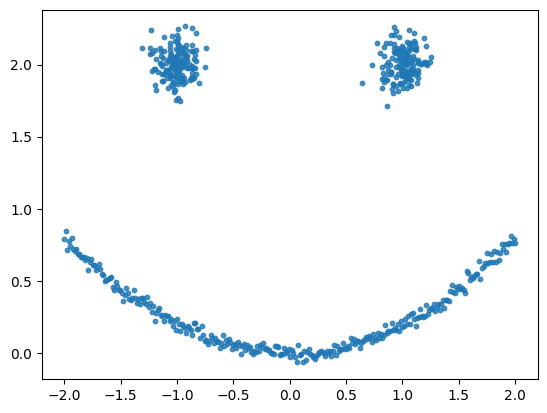

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
from PIL import Image as im

centers = [(-1, 2), (1, 2)] 
cluster_std = 0.1 
n_samples = 300 
eyes, _ = datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=8)
mouth_x = np.linspace(-2, 2, n_samples)
mouth_y = 0.2 * mouth_x ** 2 + 0.03 * np.random.randn(n_samples)
mouth = np.vstack((mouth_x, mouth_y)).T
X = np.vstack((eyes, mouth))

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 200)
plt.scatter(X[:,0],X[:,1],s=10, alpha=0.8)
plt.show()

class DBC():

    def __init__(self, dataset, min_pts, epsilon):
        self.dataset = dataset
        self.min_pts = min_pts
        self.epsilon = epsilon
        self.assignments = [-1 for _ in range (len(self.dataset))]
        self.snaps = []
    
    def snap(self, clustering, current_point):
        TEMPFILE = "temp.png"

        fig, ax = plt.subplots()
        ax.scatter(X[:, 0], X[:, 1], color=colors[clustering].tolist(), s=10, alpha=0.8)
        # Highlight the current point and its neighborhood
        if current_point is not None:
            # Draw a circle around the current point
            current_point_circle = plt.Circle((X[current_point, 0], X[current_point, 1]), 
                                              self.epsilon, color='k', fill=False)
            ax.add_artist(current_point_circle)
        fig.savefig(TEMPFILE)
        plt.close()
        self.snaps.append(im.fromarray(np.asarray(im.open(TEMPFILE))))

    def distance(self, i, j):
        return np.linalg.norm(self.dataset[i] - self.dataset[j])

    def is_core(self, i):
        return len(self.get_neighborhood(i)) >= self.min_pts
    
    def is_unassigned(self, i):
        return self.assignments[i] == -1
    
    def make_cluster(self, i, cluster_num):
        self.assignments[i] = cluster_num
        neighborhood_queue = self.get_unassigned_neighborhood(i) # TODO: maybe make this a stack of use a deque

        while neighborhood_queue:
            next_pt = neighborhood_queue.pop()
            if not self.is_unassigned(next_pt): # TODO: make this  function and improve data structure
                continue
            self.assignments[next_pt] = cluster_num # NOTE: border points will be assigned FILO
            self.snap(self.assignments, next_pt)
            if self.is_core(next_pt):
                neighborhood_queue += self.get_unassigned_neighborhood(next_pt)

        return 
    
    def get_neighborhood(self, i):
        neighborhood = []
        for j in range(len(self.dataset)):
            if i != j and self.distance(i,j) <= self.epsilon:
                neighborhood.append(j)
        return neighborhood
    
    def get_unassigned_neighborhood(self, i):
        neighborhood = self.get_neighborhood(i)
        return [point for point in neighborhood if self.is_unassigned(point)]

    def dbscan(self):
        """
        returns a list of assignments. The index of the
        assignment should match the index of the data point
        in the dataset.
        """
        cluster_num = 0
        for i in range(len(self.dataset)):
            if self.assignments[i] != -1:
                continue
            if self.is_core(i):
                # start building a new cluster
                self.make_cluster(i, cluster_num)
                cluster_num += 1

        return self.assignments
    
DB_cluster = DBC(X, 3, .2)
clustering = DB_cluster.dbscan()
images = DB_cluster.snaps

images[0].save(
    'dbscan.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)


In [ ]:
lost_tracks = []
lost_tracks_num = set()

def draw_object(object_dict,image,color = (0, 255, 0), thickness = 2, text_color= (255, 0, 0)):
  # draw box
  x = object_dict['x_min']
  y = object_dict['y_min']
  width = object_dict['width']
  height = object_dict['height']
  image = cv.rectangle(image, (x, y), (x + width, y + height), color, thickness)
  object_id = object_dict['id']
  label = str(object_id)
  cv.putText(image, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 2)

  return image

def initialize_tracks(frame_data):
    tracks = []
    next_id = 0
    for detection in frame_data:
        detection['id'] = next_id  # Assign an ID
        tracks.append(detection)
        next_id += 1
    return tracks, next_id

def compute_cost_matrix(current_detections, previous_tracks):
    cost_matrix = np.zeros((len(current_detections), len(previous_tracks)), dtype=np.float32)
    
    for i, current_det in enumerate(current_detections):
        for j, prev_track in enumerate(previous_tracks):
            # Calculate the centroid of each bounding box
            current_centroid = np.array([current_det['x_min'] + current_det['width'] / 2.0,
                                         current_det['y_min'] + current_det['height'] / 2.0])
            prev_centroid = np.array([prev_track['x_min'] + prev_track['width'] / 2.0,
                                      prev_track['y_min'] + prev_track['height'] / 2.0])
            
            # Compute the Euclidean distance between centroids
            distance = np.linalg.norm(current_centroid - prev_centroid)
            
            # Set the distance as the cost for the matrix
            cost_matrix[i, j] = distance
    
    return cost_matrix

def update_tracks(assignments, tracks, current_detections, next_id, cost_matrix):
    updated_tracks = []
    global lost_tracks, lost_tracks_num
    matched_detections = set()

    # Process assignments to update existing tracks
    for detection_idx, track_idx in assignments:
        # Ensure the detection index is within the range of current detections
        if cost_matrix[detection_idx, track_idx] < 70:
            detection = current_detections[detection_idx]
            track = tracks[track_idx]
            track['x_min'] = detection['x_min']
            track['y_min'] = detection['y_min']
            track['width'] = detection['width']
            track['height'] = detection['height']
            updated_tracks.append(track)
            matched_detections.add(detection_idx)
        else:
            if track['id'] not in lost_tracks_num: 
              lost_tracks.append(tracks[track_idx])
              lost_tracks_num.add(track['id'])
            else: 
              # Find and update the lost track with the same ID
              for lost_track in lost_tracks:
                  if lost_track['id'] == track['id']:
                      lost_track['x_min'] = track['x_min']
                      lost_track['y_min'] = track['y_min']
                      lost_track['width'] = track['width']
                      lost_track['height'] = track['height']
                      break

    # Add new tracks for unmatched detections
    for i, detection in enumerate(current_detections):
        if i not in matched_detections:
            detection['id'] = next_id
            updated_tracks.append(detection)
            next_id += 1

    print(len(lost_tracks), len(lost_tracks_num))
    return updated_tracks, next_id


def draw_objects_in_video(video_file,frame_dict):
  global lost_tracks
  # Initialize variables
  tracks, next_id = initialize_tracks(frame_dict["0"])  # Assuming frame_dict["0"] contains the initial frame detections
  
  count = 0
  cap = cv.VideoCapture(video_file)
  frames = []
  ok, image = cap.read()
  vidwrite = cv.VideoWriter("part_2_demo.mp4", cv.VideoWriter_fourcc(*'MP4V'), 30, (700,500))
  while ok:
    ######!!!!#######
    image = cv.resize(image, (700, 500)) # make sure your video is resize to this size, otherwise the coords in the data file won't work !!!
    ######!!!!#######
    obj_list = frame_dict[str(count)]
    
    # Compute cost matrix between current detections and existing tracks
    cost_matrix = compute_cost_matrix(obj_list, tracks)
  
    # Solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    
    # Update tracks with new assignments
    tracks, next_id = update_tracks(zip(row_ind, col_ind), tracks, obj_list, next_id, cost_matrix)
    

    for obj in tracks:
      image = draw_object(obj,image)
    vidwrite.write(image)
    count+=1
    ok, image = cap.read()

    if len(lost_tracks) > 0: 
       tracks = tracks + lost_tracks
  vidwrite.release()

frame_dict = load_obj_each_frame("frame_dict.json")
video_file = "commonwealth.mp4"
draw_objects_in_video(video_file,frame_dict)
